### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Class Notes: Import libraries like Tensorflow, Numpy, Pandas, pathlib, glob, keras, matplotlib have been imported below.

In [1]:
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
tf.config.run_functions_eagerly(True)
#from tensorflow import keras
#import tensorflow.keras as keras
#import tensorflow.keras as keras
import keras
from keras import models
from keras.models import Sequential
from keras import layers
from keras.layers import BatchNormalization
from keras.preprocessing.image import load_img
import glob
import warnings
warnings.filterwarnings('ignore')

### Important Library Versions:

In [2]:
print('Pandas Version is:',pd.__version__)
print('Numpy Version is:',np.__version__)
print('Tensorflow Version is:',tf.__version__)
print('Keras Version is:',keras.__version__)

Pandas Version is: 2.1.4
Numpy Version is: 1.26.4
Tensorflow Version is: 2.16.1
Keras Version is: 3.3.3


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
a= os.getcwd()
b= os.path.join(a,'DLA/ISIC')
c = os.path.join(a,'DLA/ISIC/Train')
d = os.path.join(a,'DLA/ISIC/Test')
data_dir = pathlib.Path(b)
data_dir_train = pathlib.Path(c)
data_dir_test = pathlib.Path(d)
print (b)
print(c)
print(d)

/Users/shailendra/Desktop/AIML/DLA/ISIC
/Users/shailendra/Desktop/AIML/DLA/ISIC/Train
/Users/shailendra/Desktop/AIML/DLA/ISIC/Test


In [4]:
## Below we will confirm the number of total images in the dataset and their distribution as Train and Test sets.
data_set= list(data_dir.rglob('*/*.jpg'))
image_count_set = len(list(data_dir.rglob('*/*.jpg')))
print(image_count_set)

train_d_set= list(data_dir_train.rglob('*/*.jpg'))
image_count_train = len(list(data_dir_train.rglob('*/*.jpg')))
print(image_count_train)

test_d_set= list(data_dir_test.rglob('*/*.jpg'))
image_count_test = len(list(data_dir_test.rglob('*/*.jpg')))
print(image_count_test)

2357
2239
118


In [5]:
## Now we will take a random image from the dataset and check for it's size, format, mode and type. 
img = load_img(train_d_set[2238])
print(img.size)
print(img.format)
print(img.mode)
print(type(img))
img.show()

(600, 450)
JPEG
RGB
<class 'PIL.JpegImagePlugin.JpegImageFile'>


### Load using keras.preprocessing

#### Preprocessing of Training and Validation dataset. We will create separate training and validation datasets out of images available in training data directory.

Some fixed parameters for the loader: images are processed in batches of 32 images each and each image size changed to 180*180.

In [6]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123
num_classes = 9
epochs =20 ## All models shall be trained for 20 epochs unless mentioned otherwise.

### Creation of preprocessed training & validation dataset: (80 % for training & 20 % for validation)

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,                                                           
    
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size= batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split= .2,
    subset= "training")


val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             
    labels='inferred', 
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split= .2,
    subset= "validation")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### List out all the classes of skin cance and store them in a list.

In [8]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### One instance of all the nine classes present in the training dataset have been visualised below.

2024-05-21 23:43:16.716048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


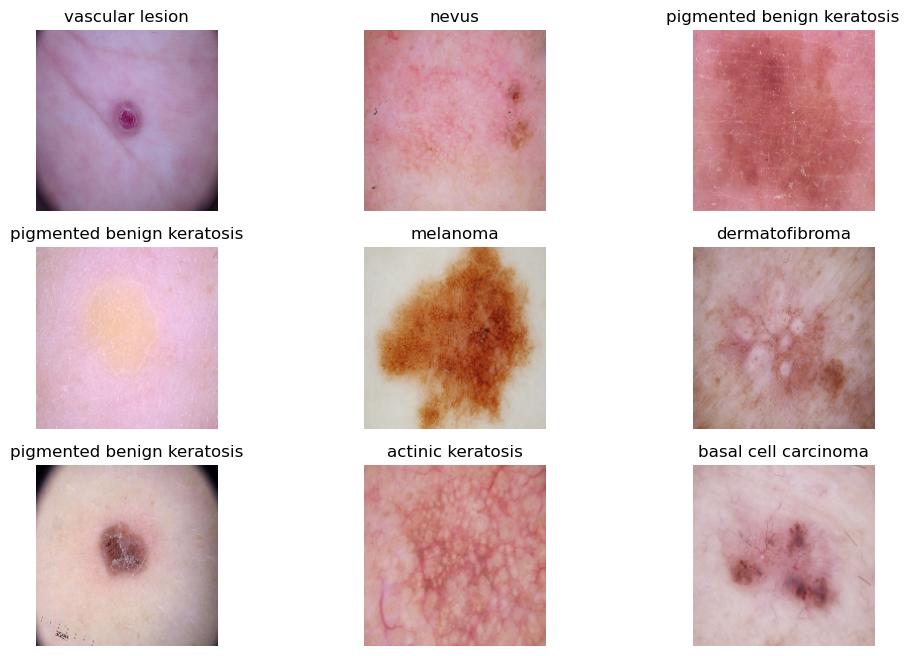

In [10]:
plt.figure(figsize=(12, 8))
labels = list(class_names)
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Initial Model

For accurate detection of 9 classes present in the dataset below is a sequential model built in Keras. The model consist of Five convolutional layers of 2x32, 2x64 and 128 features each using 3x3 kernel. 'relu' activation function have been used in all three convolutional layers. Pixel values of images have been rescaled between 0 and 1 using standardisation method of rescaling. Each convolutional layer have been followed by a 2*2 Max pooling layer. At the end Dense layer with 128 features with 'relu' have been used and it is followed by another dense layer for classification with 'softmax' as activation function.

Further, to keep the output image size same as input, we have used padding as 'same' and used strides of 1 pixel in both directions.

In [10]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(256, activation='relu'),

  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

## Model Compilation, Fitting, Visualization of Results and Summary.
'adam' optimiser and 'SparseCategoricalCrossentropy' loss function have been used for their obvious advantages as learned from theory.
Since we will not be making any change in optimiser and loss function, code for model compilation, model fitting, model summary and visualisation will remain same. Therefore, it's better to define a function for these repetitive actions. For this purpose function named model_compilation_fit_summary have been and defined and shall be used for later instances of the model compilation, fitting and visualisation.

In [11]:
def model_compilation_fit_summary():
 model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

 history = model.fit(train_ds,validation_data=val_ds,epochs=epochs )

 model.summary()

 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']

 loss = history.history['loss']
 val_loss = history.history['val_loss']

 epochs_range = range(epochs)

 plt.figure(figsize=(12, 4))
 plt.subplot(1, 2, 1)
 plt.plot(epochs_range, acc, label='Training Accuracy', color='green')
 plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
 plt.legend(loc='best')
 plt.title('Training and Validation Accuracy')

 plt.subplot(1, 2, 2)
 plt.plot(epochs_range, loss, label='Training Loss',color='blue')
 plt.plot(epochs_range, val_loss, label='Validation Loss',color='orange')
 plt.legend(loc='best')
 plt.title('Training and Validation Loss')
 plt.show()

**Compilation, Training & Fitting, Summary and Visualization of Initial Model**

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 903ms/step - accuracy: 0.1955 - loss: 2.3359 - val_accuracy: 0.2282 - val_loss: 2.0558
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 935ms/step - accuracy: 0.2235 - loss: 2.0165 - val_accuracy: 0.2908 - val_loss: 1.8810
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.2830 - loss: 1.8629 - val_accuracy: 0.4519 - val_loss: 1.7887
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4417 - loss: 1.5656 - val_accuracy: 0.4877 - val_loss: 1.5023
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4863 - loss: 1.4580 - val_accuracy: 0.4966 - val_loss: 1.5036
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5114 - loss: 1.4012 - val_accuracy: 0.5280 - val_loss: 1.4487
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5399 - loss: 1.3012 - val_accuracy: 0.4787 - val_loss: 1.4701
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5671 - loss: 1.2026 - val_accuracy: 0.5168 - val

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 180, 180, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 180, 180, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 90, 90, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 90, 90, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 90, 90, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 45, 45, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 45, 45, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 61952)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 256)              │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 9)                │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,005,117 (183.12 MB)

 Trainable params: 16,001,705 (61.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,003,412 (122.08 MB)

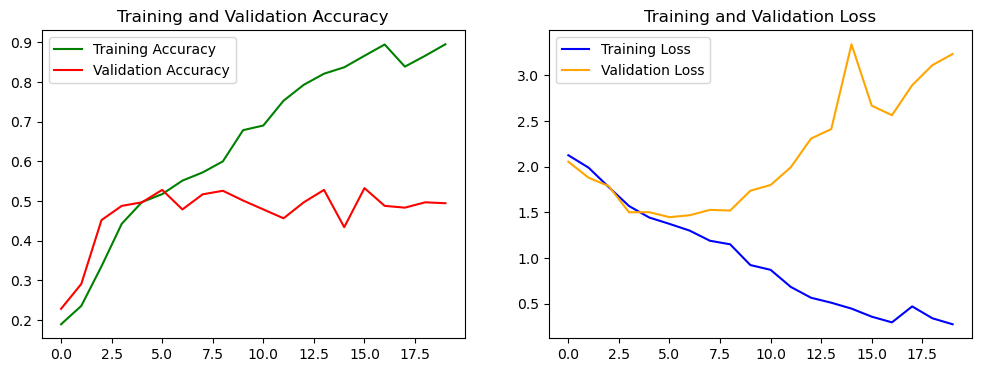

In [12]:
model_compilation_fit_summary()

## Observations about the model & it's performance:

From the above plots, it is clearly evident that the model is overfitting. While training accuracy is continuously increasing with every epoch, validation accuracy remains stagnated just above 40 %. Similary, the training loss is continuousy decreasing with every epoch but reverse is happening with validation loss. Both of these establishes clear overfitting of the model.

### Strategy to solve overftting issue.

To address the issue of overfitting, initially we will use the data augmentation techniques including random flip, random roation and random zoom of the images. 
In the next step of addressal of overfitting issue, we will use dropout of .25 in the model itself. 

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomCrop(img_height,img_width),
  ]
)

### Visualization of how augmentation strategy works for one instance of training image.isualization of how augmentation strategy works for one instance of training image.

2024-05-22 00:04:40.879122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


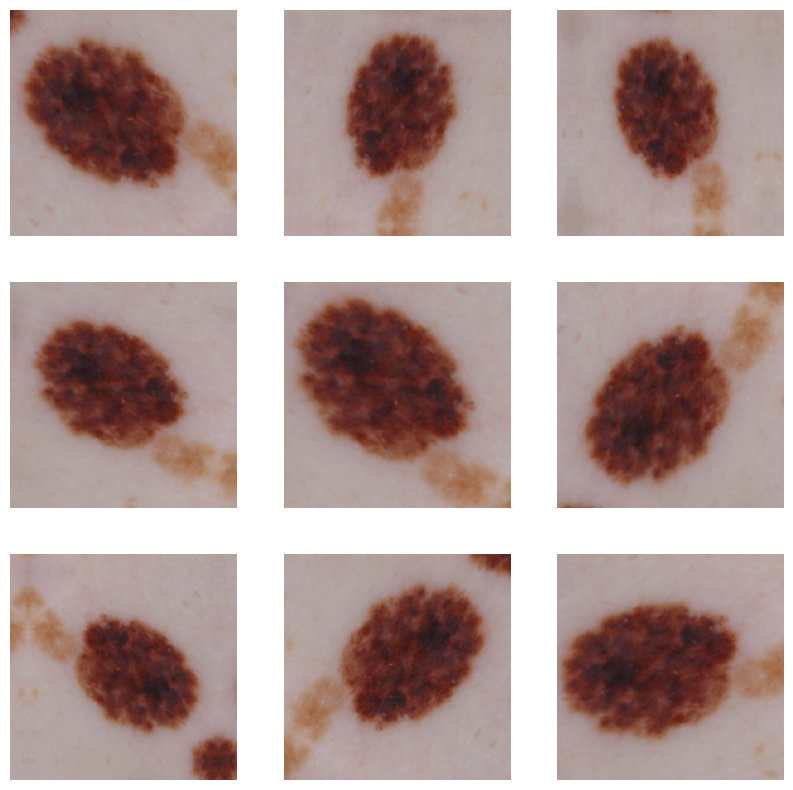

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### New model with dropout layer and data_augmentation.



In [14]:
model = Sequential([data_augmentation,
  tf.keras.layers.Rescaling(1./255),
                    
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
                    
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
                    
  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
                    
  tf.keras.layers.Dropout(0.25),
                    
  tf.keras.layers.Flatten(),
                    
  tf.keras.layers.Dense(256, activation='relu'),
                    
  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

**Compilation, Training & Fitting, Summary and Visualization of model with Image Augmentation and Use of dropout layer**

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 54s 969ms/step - accuracy: 0.1964 - loss: 2.1583 - val_accuracy: 0.2573 - val_loss: 2.0513
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.2218 - loss: 2.0416 - val_accuracy: 0.2058 - val_loss: 2.0398
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.2058 - loss: 2.0352 - val_accuracy: 0.2841 - val_loss: 1.9682
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.2457 - loss: 1.9342 - val_accuracy: 0.2975 - val_loss: 1.8385
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.3559 - loss: 1.7422 - val_accuracy: 0.4183 - val_loss: 1.5981
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.3835 - loss: 1.6834 - val_accuracy: 0.3982 - val_loss: 1.6717
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.4048 - loss: 1.6414 - val_accuracy: 0.4228 - val_loss: 1.6384
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.4447 - loss: 1.5540 - val_accuracy: 0.4049 - val_lo

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 180, 180, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 180, 180, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 90, 90, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 90, 90, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 90, 90, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 45, 45, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 45, 45, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 61952)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 256)              │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 9)                │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,005,117 (183.12 MB)

 Trainable params: 16,001,705 (61.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,003,412 (122.08 MB)

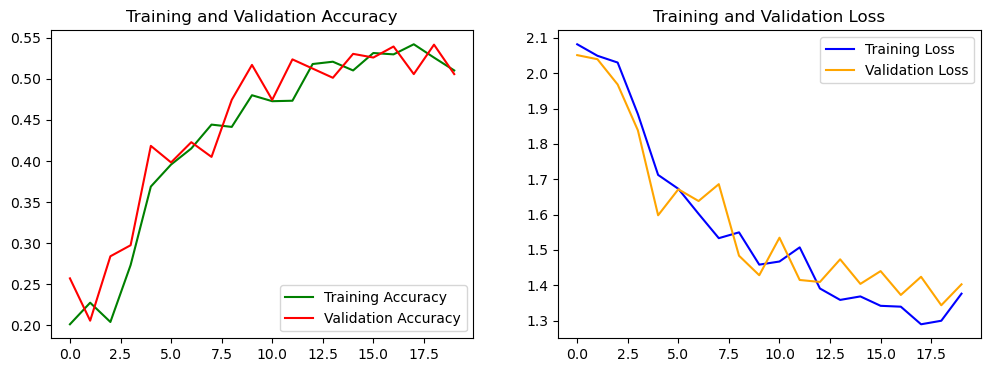

In [15]:
model_compilation_fit_summary()

#### Observations:

While the issue of overfitting seems to be addressed as there is a downward trend in the validation loss function. However, there comes a significant reduction in the training accuraccy without any observable change in the validation accuracy. Therefore, we can say to some extent that now this seems a case of uderfitting. Since the model accuracy has decreased significanly, we will now visualise the distribution of class data for some latent clues.

## Class Distribution:

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
[114, 376, 95, 438, 357, 462, 77, 181, 139]


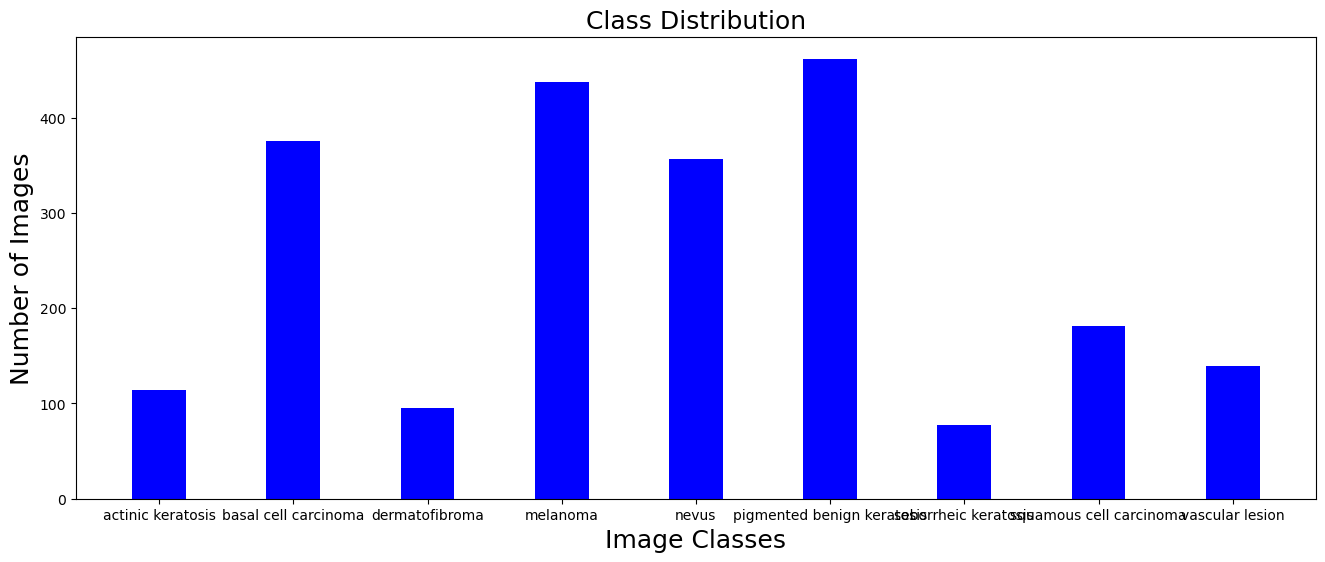

In [16]:
class_count_list=[]
for i in range(9): 
  
 class_data_path = os.path.join(data_dir_train,class_names[i])
 class_data = pathlib.Path(class_data_path)
 
 data_set= list(class_data.glob('*.jpg'))
 image_count= len(list(class_data.glob('*.jpg')))
 class_count_list.append(image_count)
print(class_names)
print(class_count_list)

plt.figure(figsize=(16, 6))
plt.ylabel('Number of Images', fontsize =18)
plt.xlabel('Image Classes', fontsize =18)
plt.title('Class Distribution', fontsize =18)
plt.bar(class_names, class_count_list, color ='blue', width =0.4)
plt.show()

## Findings about class distribution:

Class Seborrheic Keratosis is having least number of images ie. only 77.

Class Distribution is dominated by Pigmented Benign Keratosis and Melanoma classes both of them are represented by more than 425 images each which is more than 500 % times of the representation of the class Seborrheic Keratosis and more than 400 % times of the representation of the class Dermatofibroma.

Now we can attribute the low accuracy of our above model to the issue of class imbalance in the training data.


## Rectification of the class imbalance.

we will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the class remain under represented.

We will add 500 images per class of the training data so that the least representative class size will increase to 577 images which will be more than 50 % of the size of the highest representation class with 962 images.

In [17]:
!pip install Augmentor

To use `Augmentor`, the following general procedure have been followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [18]:
path_to_training_dataset= pathlib.Path(data_dir_train)
print(path_to_training_dataset)
import Augmentor
for i in class_names:
    print(str(path_to_training_dataset) + '/' +i)
    p = Augmentor.Pipeline(str(path_to_training_dataset) + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

/Users/shailendra/Desktop/AIML/DLA/ISIC/Train
/Users/shailendra/Desktop/AIML/DLA/ISIC/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /Users/shailendra/Desktop/AIML/DLA/ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3690270D0>: 100%|█|


/Users/shailendra/Desktop/AIML/DLA/ISIC/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /Users/shailendra/Desktop/AIML/DLA/ISIC/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


/Users/shailendra/Desktop/AIML/DLA/ISIC/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /Users/shailendra/Desktop/AIML/DLA/ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x367557F10>: 100%|█|


/Users/shailendra/Desktop/AIML/DLA/ISIC/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /Users/shailendra/Desktop/AIML/DLA/ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x301112150>: 100%|█


/Users/shailendra/Desktop/AIML/DLA/ISIC/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /Users/shailendra/Desktop/AIML/DLA/ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x368B9A6D0>: 100%|█|


/Users/shailendra/Desktop/AIML/DLA/ISIC/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /Users/shailendra/Desktop/AIML/DLA/ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x369007D90>: 100%|█|


/Users/shailendra/Desktop/AIML/DLA/ISIC/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /Users/shailendra/Desktop/AIML/DLA/ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x37BD2B1D0>: 100%|█


/Users/shailendra/Desktop/AIML/DLA/ISIC/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /Users/shailendra/Desktop/AIML/DLA/ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3668371D0>: 100%|█|


/Users/shailendra/Desktop/AIML/DLA/ISIC/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /Users/shailendra/Desktop/AIML/DLA/ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x368F876D0>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [19]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
[614, 876, 595, 938, 857, 962, 577, 681, 639]


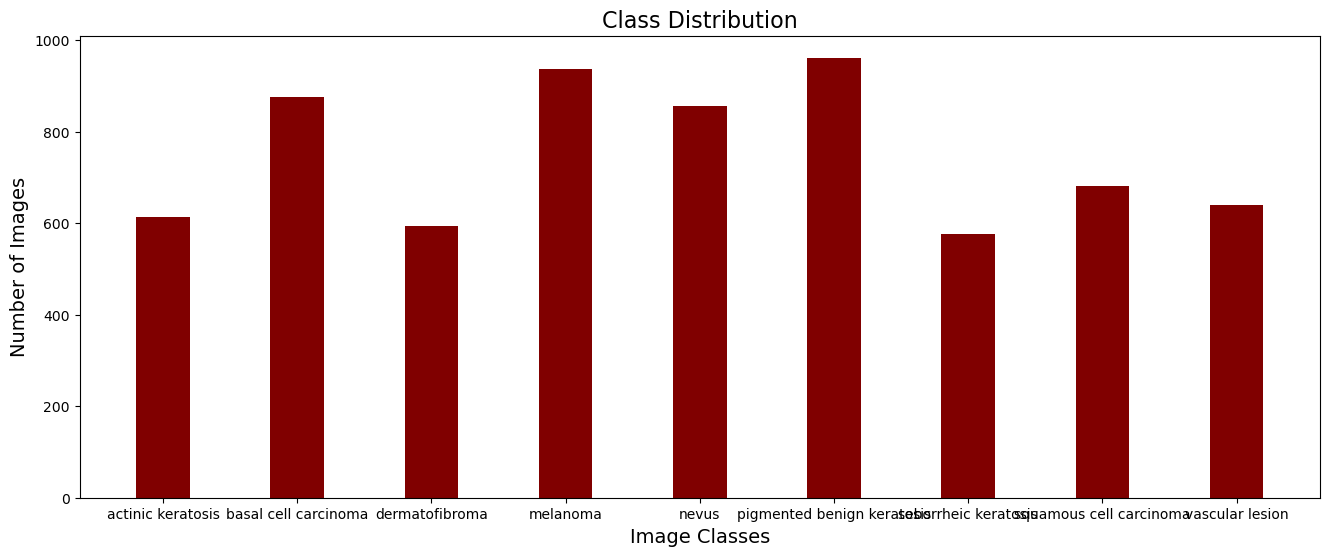

In [20]:
class_count_list=[]
for i in range(9): 
 class_data_path = os.path.join(data_dir_train,class_names[i])
 class_data = pathlib.Path(class_data_path)
 
 data_set= list(class_data.rglob('*.jpg'))
 image_count= len(list(class_data.rglob('*.jpg')))
 class_count_list.append(image_count)
print(class_names)
print(class_count_list)

plt.figure(figsize=(16, 6))
plt.xlabel('Image Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Class Distribution',fontsize =16)
plt.bar(class_names, class_count_list, color ='maroon', width =0.4)
plt.show()

### As clearly visible above, classes are more balanced now and each class is very well represented.Neither of the class is overly dominant either.

### Training of  the model on the augmented training dataset.

### Creation of training and validation data from augmented dataset.

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)



val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Sequential Model with augmented class data.

In [22]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  
    
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  
    
  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Dropout(0.25),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  
    
  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])


### Compilation, Fitting, Summary and Visualisation of Model with augmented class data.

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.1650 - loss: 2.1936 - val_accuracy: 0.2257 - val_loss: 2.0298
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.3523 - loss: 1.6689 - val_accuracy: 0.4811 - val_loss: 1.3564
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.4819 - loss: 1.3723 - val_accuracy: 0.5204 - val_loss: 1.2826
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.5579 - loss: 1.2011 - val_accuracy: 0.6006 - val_loss: 1.0823
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.5935 - loss: 1.0969 - val_accuracy: 0.6273 - val_loss: 1.0058
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.6806 - loss: 0.8678 - val_accuracy: 0.6474 - val_loss: 1.0020
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.7665 - loss: 0.6349 - val_accuracy: 0.7253 - val_loss: 0.7847
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.7870 - loss: 0.5902 - val_accu

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 180, 180, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 180, 180, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 90, 90, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 90, 90, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 90, 90, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 45, 45, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 45, 45, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 61952)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 256)              │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 9)                │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,005,117 (183.12 MB)

 Trainable params: 16,001,705 (61.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,003,412 (122.08 MB)

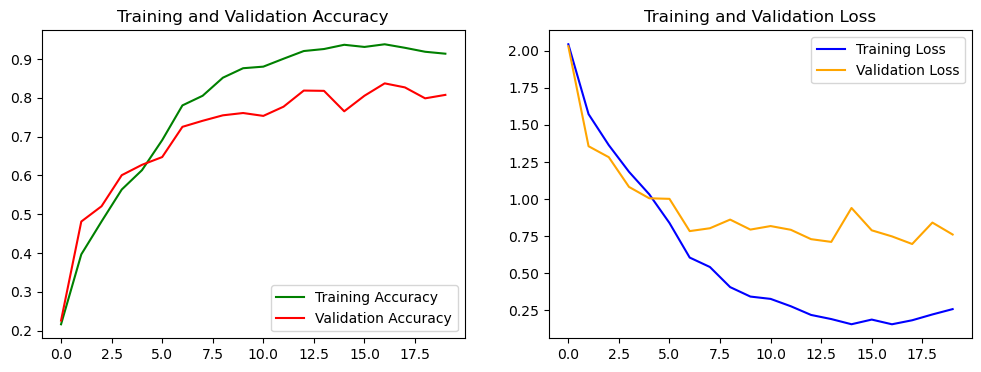

In [23]:
model_compilation_fit_summary()

In [24]:
### Model with Batch Normalization after first convolutional layer.

In [25]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  
    
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  
    
  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Dropout(0.25),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  
    
  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.2743 - loss: 2.2796 - val_accuracy: 0.1136 - val_loss: 2.1701
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.4757 - loss: 1.3758 - val_accuracy: 0.4180 - val_loss: 1.7857
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.6407 - loss: 0.9980 - val_accuracy: 0.6422 - val_loss: 1.1017
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.7393 - loss: 0.6990 - val_accuracy: 0.7216 - val_loss: 0.8259
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8284 - loss: 0.4564 - val_accuracy: 0.6370 - val_loss: 1.0989
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8634 - loss: 0.3630 - val_accuracy: 0.7454 - val_loss: 0.8120
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.8886 - loss: 0.3028 - val_accuracy: 0.7587 - val_loss: 0.8003
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.9122 - loss: 0.2277 - val_accu

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 180, 180, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 180, 180, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 180, 180, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 90, 90, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 90, 90, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (32, 90, 90, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 45, 45, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (32, 45, 45, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (32, 61952)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 256)              │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 9)                │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,005,373 (183.13 MB)

 Trainable params: 16,001,769 (61.04 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 32,003,540 (122.08 MB)

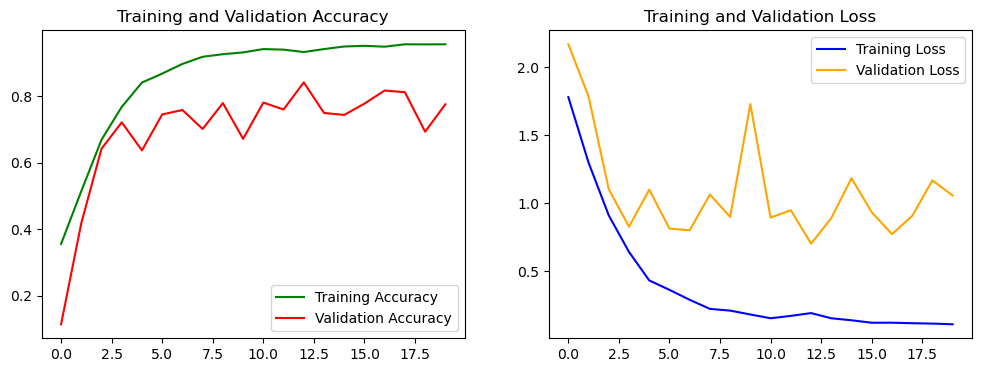

In [26]:
model_compilation_fit_summary()

In [33]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  
    
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),

    
  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Dropout(0.4),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),

    
  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.3205 - loss: 2.2962 - val_accuracy: 0.1351 - val_loss: 2.1881
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.5175 - loss: 1.2814 - val_accuracy: 0.4477 - val_loss: 1.5914
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.6112 - loss: 1.0503 - val_accuracy: 0.5605 - val_loss: 1.2990
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.7130 - loss: 0.7975 - val_accuracy: 0.6630 - val_loss: 0.9287
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.7813 - loss: 0.5833 - val_accuracy: 0.5457 - val_loss: 1.7686
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8278 - loss: 0.4586 - val_accuracy: 0.6845 - val_loss: 0.9866
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.8657 - loss: 0.3600 - val_accuracy: 0.7283 - val_loss: 0.8181
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.8919 - loss: 0.3115 - val_accu

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (32, 180, 180, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (32, 180, 180, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (32, 180, 180, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (32, 90, 90, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (32, 90, 90, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (32, 45, 45, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (32, 45, 45, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (32, 61952)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (32, 256)              │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (32, 9)                │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,894,589 (182.70 MB)

 Trainable params: 15,964,841 (60.90 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 31,929,684 (121.80 MB)

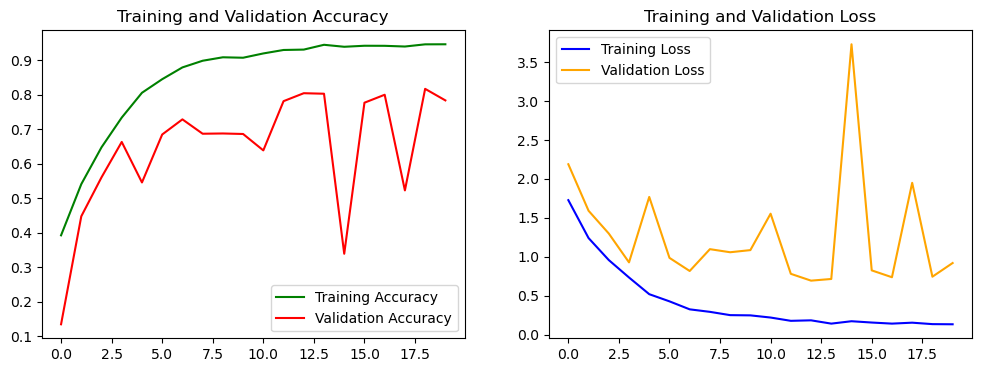

In [34]:
model_compilation_fit_summary()

In [36]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.BatchNormalization(),
  #tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  
    
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),

    
  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Dropout(0.4),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),

    
  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 96s 565ms/step - accuracy: 0.2285 - loss: 2.6733 - val_accuracy: 0.1990 - val_loss: 2.1851
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 101s 599ms/step - accuracy: 0.4070 - loss: 1.5692 - val_accuracy: 0.1559 - val_loss: 2.1643
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 113s 669ms/step - accuracy: 0.5059 - loss: 1.3495 - val_accuracy: 0.4781 - val_loss: 1.4501
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 113s 670ms/step - accuracy: 0.6095 - loss: 1.0803 - val_accuracy: 0.5212 - val_loss: 1.5440
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 114s 676ms/step - accuracy: 0.7204 - loss: 0.7878 - val_accuracy: 0.5427 - val_loss: 1.4221
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 115s 678ms/step - accuracy: 0.8039 - loss: 0.5493 - val_accuracy: 0.6214 - val_loss: 1.0850
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 117s 691ms/step - accuracy: 0.8371 - loss: 0.4625 - val_accuracy: 0.7305 - val_loss: 0.9611
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 123s 730ms/step - accuracy: 0.8910 - 

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)         │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (32, 180, 180, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (32, 180, 180, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (32, 90, 90, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (32, 90, 90, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (32, 45, 45, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (32, 45, 45, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (32, 22, 22, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (32, 61952)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (32, 256)              │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (32, 9)                │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,866,845 (182.60 MB)

 Trainable params: 15,955,593 (60.87 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 31,911,188 (121.73 MB)

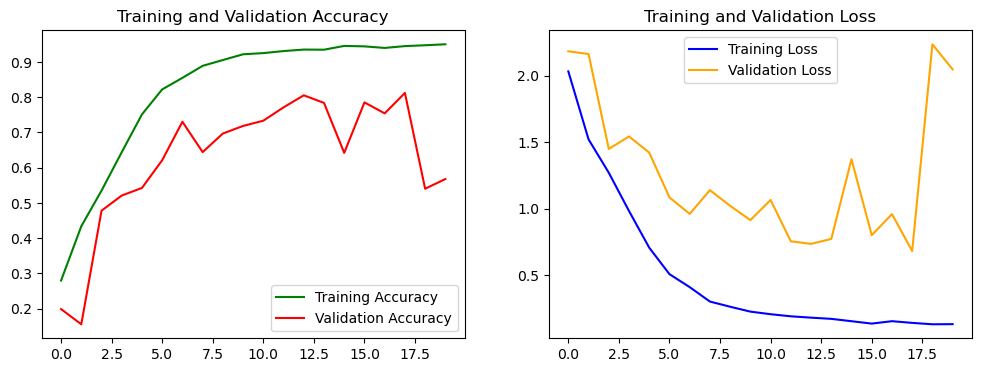

In [37]:
model_compilation_fit_summary()

In [40]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  
    
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),  
  tf.keras.layers.MaxPooling2D(),

    
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),

    
  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 76s 450ms/step - accuracy: 0.2754 - loss: 2.0057 - val_accuracy: 0.1915 - val_loss: 2.2206
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 491ms/step - accuracy: 0.5024 - loss: 1.3429 - val_accuracy: 0.3549 - val_loss: 1.7731
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 88s 519ms/step - accuracy: 0.6047 - loss: 1.0793 - val_accuracy: 0.5301 - val_loss: 1.3054
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 94s 559ms/step - accuracy: 0.6927 - loss: 0.8470 - val_accuracy: 0.6214 - val_loss: 1.0051
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 97s 576ms/step - accuracy: 0.7987 - loss: 0.5655 - val_accuracy: 0.7320 - val_loss: 0.7425
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 100s 590ms/step - accuracy: 0.8590 - loss: 0.3949 - val_accuracy: 0.7528 - val_loss: 0.7333
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 100s 592ms/step - accuracy: 0.8813 - loss: 0.3124 - val_accuracy: 0.5189 - val_loss: 1.8044
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 101s 599ms/step - accuracy: 0.8890 - loss

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_12 (Rescaling)        │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (32, 180, 180, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (32, 180, 180, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (32, 180, 180, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (32, 90, 90, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (32, 90, 90, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (32, 90, 90, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (32, 45, 45, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (32, 45, 45, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (32, 22, 22, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (32, 22, 22, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (32, 30976)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (32, 128)              │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (32, 9)                │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,004,237 (45.79 MB)

 Trainable params: 4,001,401 (15.26 MB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 8,002,804 (30.53 MB)

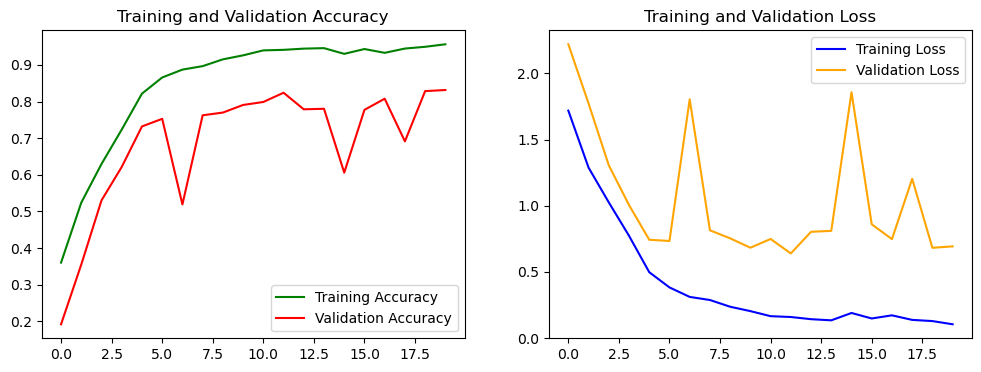

In [41]:
model_compilation_fit_summary()

In [42]:
model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(16, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
  
    
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same',strides=(1,1)),  
  tf.keras.layers.MaxPooling2D(),

    
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same',strides=(1,1)),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),

    
  tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 391ms/step - accuracy: 0.1624 - loss: 2.1742 - val_accuracy: 0.2940 - val_loss: 1.8864
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 74s 439ms/step - accuracy: 0.3738 - loss: 1.6556 - val_accuracy: 0.5078 - val_loss: 1.2873
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 486ms/step - accuracy: 0.5618 - loss: 1.1709 - val_accuracy: 0.5947 - val_loss: 1.1500
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 493ms/step - accuracy: 0.6924 - loss: 0.8128 - val_accuracy: 0.6875 - val_loss: 1.0215
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 501ms/step - accuracy: 0.7944 - loss: 0.5666 - val_accuracy: 0.7001 - val_loss: 1.0604
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 89s 527ms/step - accuracy: 0.8624 - loss: 0.4030 - val_accuracy: 0.7350 - val_loss: 1.0329
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 88s 518ms/step - accuracy: 0.8852 - loss: 0.3134 - val_accuracy: 0.7424 - val_loss: 1.0451
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 88s 520ms/step - accuracy: 0.9151 - loss: 0

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)        │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (32, 180, 180, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (32, 180, 180, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (32, 90, 90, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (32, 90, 90, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (32, 90, 90, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (32, 45, 45, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (32, 45, 45, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (32, 22, 22, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (32, 22, 22, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (32, 30976)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (32, 128)              │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (32, 9)                │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,004,109 (45.79 MB)

 Trainable params: 4,001,369 (15.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,002,740 (30.53 MB)

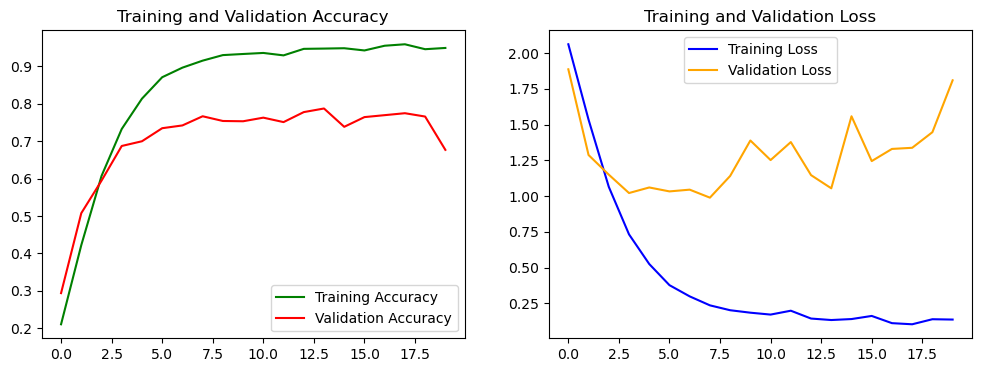

In [44]:
model_compilation_fit_summary()

## Analysis of Models and Results.

 Various models have been prepared after the stage of class augmentation. Model developed initially works well after removal of  the class imbalance. For further improvements in validation accuracy, many variations in the model have been attempted including the introduction of Batch Normalization after first convolutional layer but none of the later models seems to make any significant improvement in the validation accuracy. It appears that further improvement in the class data augmentation will hopefully improve the validation accuracy as well. 